# Regression Analysis

In [1]:
# Libraries for working with and plotting data
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
# Importing own classes and functions
from linearReg import LinearReg
from gdOptimizers import GDOptimizers
from gridTest import gridTest, gridCV, mseCV
from FFNN import FFNN
# Tensorflow/keras to compare neural network performance
from tensorflow.keras.layers import Input, LeakyReLU
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function

## Setup of data

In [2]:
def franke(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [3]:
def data(n = 100):
    x = np.random.rand(n) #an array of n unordered uniform random numbers from 0 to 1
    y = np.random.rand(n)
    xy = np.column_stack((x, y))
    
    noise = np.random.randn(n) / 10
    z = np.array([franke(x, y) + noise]).T
    return xy, z

In [4]:
xy, z = data(400)
xy_train, xy_test, z_train, z_test = train_test_split(xy, z, test_size = 0.8)
xy_cv, temp, z_cv, temp = train_test_split(xy, z, test_size = 0.75)

## Ridge regression with SGD

### Analytical Solution

In [5]:
orders = [i for i in range(3, 18)]
lmdas = np.logspace(-10, 0, 15)
optimal = [np.Inf, 0, 0]
for order in orders:
    for lmda in lmdas:
        model = LinearReg(order = order, lmda = lmda, sgd = None, analytical = True)
        
        mse = mseCV(model, xy_cv, z_cv, kfolds = 5)
        if mse < optimal[0]:
            optimal[0] = mse
            optimal[1] = order
            optimal[2] = lmda
            
print(f"The best analytical fit to the franke function was had a mse of {optimal[0]:.4f},\nand was found using order = {optimal[1]} and lmda = {optimal[2]:.4f}")

The best analytical fit to the franke function was had a mse of 0.0139,
and was found using order = 4 and lmda = 0.0001


### Example model

In [6]:
sgd = GDOptimizers(learning_rate = 0.01, epochs = 100, batch_size = 10, optimizer = "SGD")
model = LinearReg(order = 4, lmda = 1E-4, sgd = sgd)

model.fit(xy_train, z_train)
z_train_mdl = model.predict(xy_train)
z_mdl = model.predict(xy_test)

print(f"Mean squared error on training data = {mean_squared_error(z_train_mdl, z_train):.4f}")
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")

Mean squared error on training data = 0.0640
Mean squared error = 0.0904


In [7]:
sgd = GDOptimizers(learning_rate = 0.01, epochs = 1000, batch_size = 10, optimizer = "momentum", alpha=0.5)
model = LinearReg(order = 4, lmda = 1E-4, sgd = sgd)

model.fit(xy_train, z_train)
z_train_mdl = model.predict(xy_train)
z_mdl = model.predict(xy_test)

print(f"Mean squared error on training data = {mean_squared_error(z_train_mdl, z_train):.4f}")
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")

Mean squared error on training data = 0.0192
Mean squared error = 0.0244


### Grid search for best performing parameters

In [8]:
def createRidge(eta, lmda, params):
    sgd = GDOptimizers(learning_rate = eta, epochs = 1000, batch_size = 10, optimizer = "momentum")
    model = LinearReg(order = params["order"], lmda = lmda, sgd = sgd)
    return model

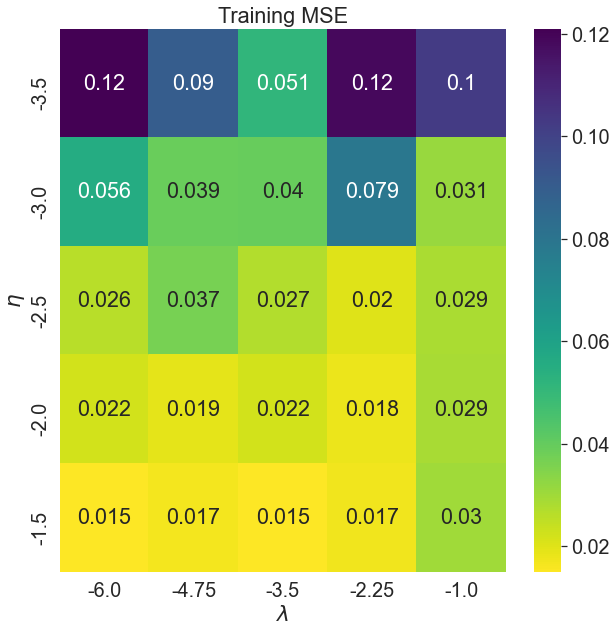

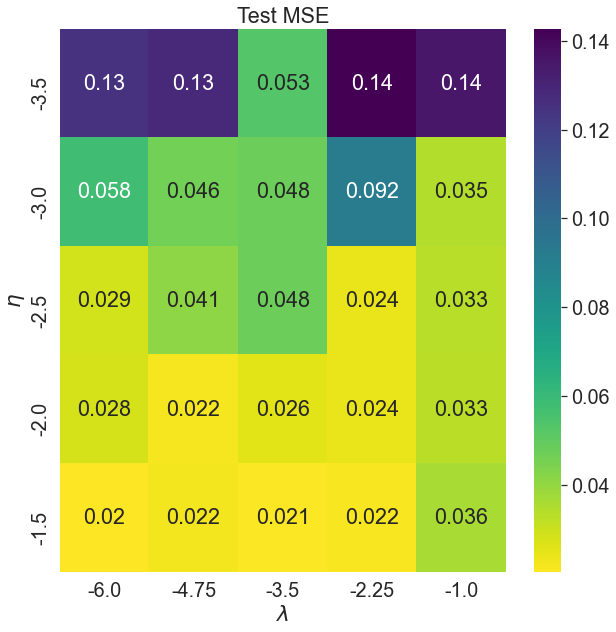

In [9]:
etas = np.logspace(-3.5, -1.5, 5)
lmdas = np.logspace(-6, -1, 5)

params = {"order": 4}
#gridTest(etas, lmdas, createRidge, params, 'mse', xy_train, xy_test, z_train, z_test)
gridCV(etas, lmdas, createRidge, params, 'mse', xy_cv, z_cv)

## Regression using our Feed Forward Neural Network

### Example model

In [10]:
nn = FFNN(inputs = 2)
nn.addLayer(neurons = 12, activation = "leakyrelu")
nn.addLayer(neurons = 1, activation = "linear")

sgd = GDOptimizers(learning_rate = 0.00005, epochs = 1000, batch_size = 10, optimizer = "momentum")
nn.compile(loss="mse", optimizer=sgd, lmda = 0.01)

z_mdl = nn.predict(xy_test)
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")
z_mdl = nn.predict(xy_train)
print(f"Mean squared error on training data = {mean_squared_error(z_mdl, z_train):.4f}")

nn.fit(xy_train, z_train)
z_train_mdl = nn.predict(xy_train)
z_mdl = nn.predict(xy_test)

print(f"Mean squared error on training data = {mean_squared_error(z_train_mdl, z_train):.4f}")
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")

Mean squared error = 0.2356
Mean squared error on training data = 0.2302
Mean squared error on training data = 0.1583
Mean squared error = 0.1640


### Grid search for best performing parameters

In [11]:
def createNN(eta, lmda, params):
    nn = FFNN(inputs = params["inputs"])
    for nrons, activation in zip(params["neurons"], params["activations"]):
        nn.addLayer(neurons = nrons, activation = activation)

    sgd = GDOptimizers(learning_rate = eta, epochs = 1000, batch_size = 10, optimizer = "momentum")
    nn.compile(loss="mse", optimizer=sgd, lmda = lmda)
    return nn

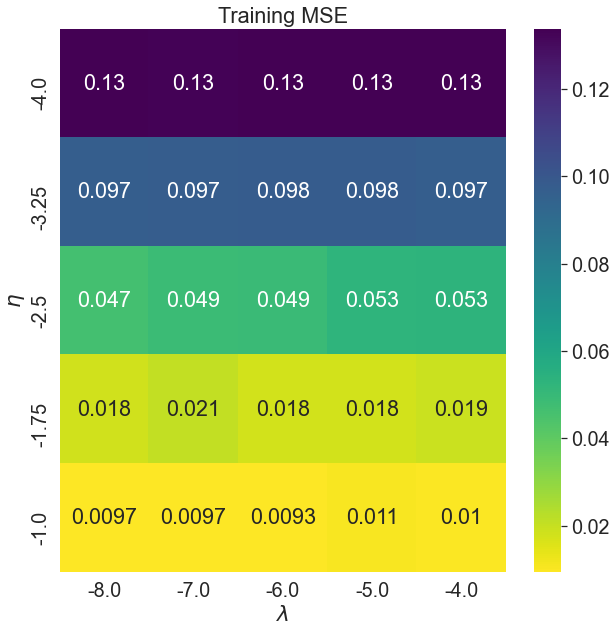

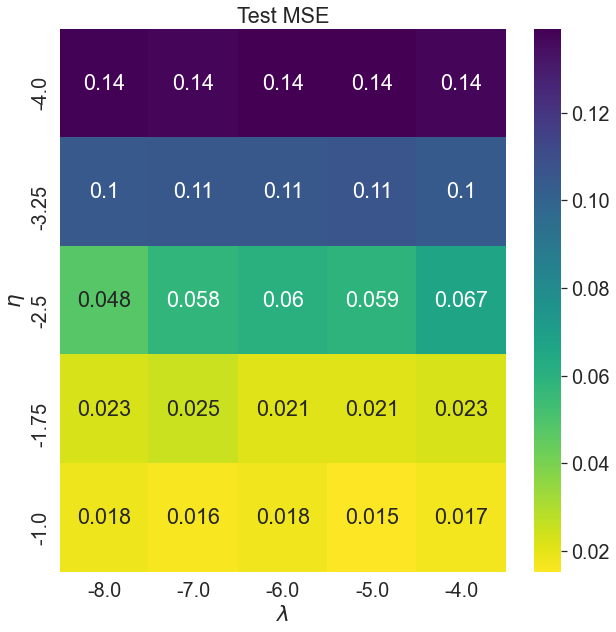

In [12]:
etas = np.logspace(-4, -1, 5)
lmdas = np.logspace(-8, -4, 5)

params = {"inputs": 2, "neurons":[20, 20, 1], "activations":["leakyrelu", "leakyrelu", "linear"]}
#gridTest(etas, lmdas, createNN, params, 'mse', xy_train, xy_test, z_train, z_test)
gridCV(etas, lmdas, createNN, params, 'mse', xy_cv, z_cv)

## Regression with Tensorflow

### Example model

In [13]:
model = Sequential()
model.add(Dense(30, activation='linear'))
model.add(LeakyReLU(alpha=0.01))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(1, activation="linear"))

eta = 0.001
sgd = optimizers.SGD(lr=eta)
model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
model.fit(xy_train, z_train, epochs=1000, batch_size=10, verbose=0)
#scores = model.evaluate(xy_test, z_test)

z_mdl = model.predict(xy_test)
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")

Mean squared error = 0.0339


### Grid search for best performing parameters

In [14]:
def createNNTF(eta, lmda, params):
    model = Sequential()
    for nrons, activation in zip(params["neurons"], params["activations"]):
        model.add(Dense(nrons, activation=activation, kernel_regularizer=regularizers.l2(lmda)))
        
    sgd = optimizers.SGD(lr=eta)
    model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
    return model

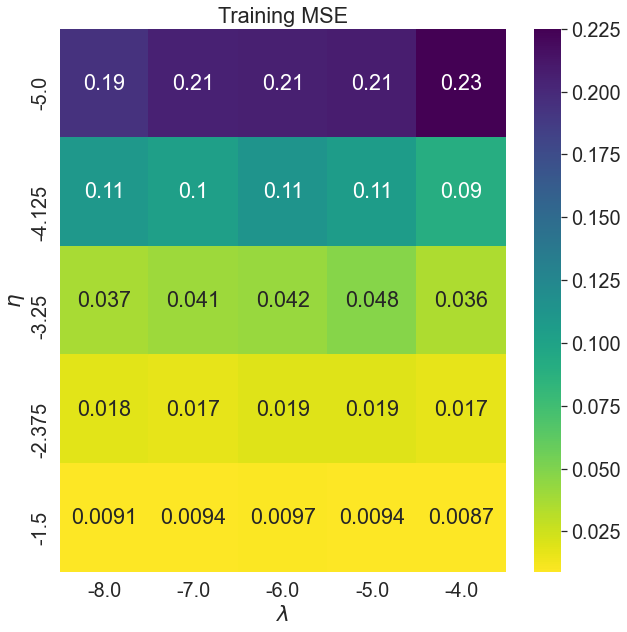

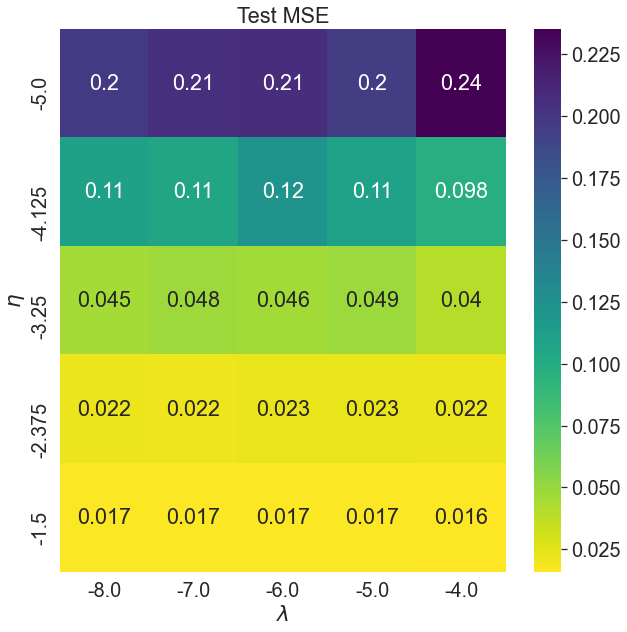

In [16]:
etas = np.logspace(-5, -1.5, 5)
lmdas = np.logspace(-8, -4, 5)

params = {"neurons":[30, 20, 1], "activations":["relu", "relu", "linear"]}

#gridTest(etas, lmdas, createNNTF, params, 'mse', xy_train, xy_test, z_train, z_test, usingTensorFlow=True)
gridCV(etas, lmdas, createNNTF, params, 'mse', xy_cv, z_cv, usingTensorFlow=True)